In [1]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# regex
import re

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [40]:
# imputation ... MICE .. simple principle components 

In [3]:
# support vector machines 
# good for high dimensional low sample data
#see if makes improvements 

---

&nbsp;

...

&nbsp;

---

# Analyzing Telomere Length Data from TeloFISH
---

## Mean Telomere Length analyses

### Visualizations

In [2]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
all_patients_df['telo data'] = all_patients_df['telo data'].map(literal_eval)
all_patients_df.head()

,patient id,timepoint,telo data,chr data,status,telo means,Q1,Q2-3,Q4
0,1,1 non irrad,"[51.73743011870811, 79.18915215980653, 83.4125...",chr data,IT WORKS PEGGY <333,84.796483,1195.0,2225.0,1180.0
1,1,2 irrad @ 4 Gy,"[105.58659207899615, 115.0893853661058, 97.139...",chr data,IT WORKS PEGGY <333,90.975826,724.0,2350.0,1526.0
2,1,3 B,"[73.9106144552973, 87.6368714255668, 191.10982...",chr data,IT WORKS PEGGY <333,116.779989,231.0,1457.0,2912.0
3,1,4 C,"[82.35671824619878, 92.91527186750632, 114.033...",chr data,IT WORKS PEGGY <333,99.346299,372.0,2241.0,1987.0
4,2,1 non irrad,"[120.95586689380465, 115.05443014805594, 78.66...",chr data,IT WORKS PEGGY <333,119.773675,1166.0,2270.0,1164.0


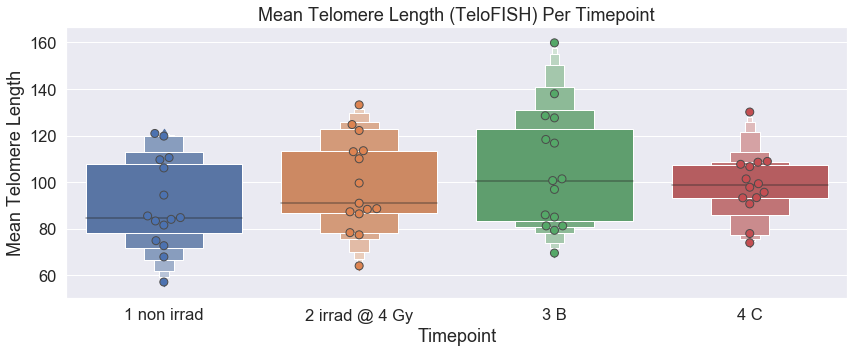

In [10]:
fig = plt.figure(figsize=(14,5))
ax = sns.set(font_scale = 1.5)
ax = sns.boxenplot(x='timepoint',y='telo means', data=all_patients_df,
                  linewidth=1)
ax = sns.swarmplot(x='timepoint',y='telo means', data=all_patients_df, size=8,
                  linewidth=1)

ax.set_title("Mean Telomere Length (TeloFISH) Per Timepoint") 
ax.set_ylabel('Mean Telomere Length')
ax.set_xlabel('Timepoint')
plt.savefig('../graphs/telomere length/all patient telomere length means teloFISH.png', dpi=400)

### Correlations, Linear Regressions

In [120]:
lin_reg_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='telo means')
lin_reg_df = lin_reg_df.drop(13)
lin_reg_df['constant'] = 1

lin_reg_df.head(4)

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
patient id,,,,,
1,84.796738,90.975987,116.780229,99.346663,1
2,119.774143,133.199629,159.828115,108.915685,1
3,83.351204,87.295754,101.433049,95.669819,1
5,85.506373,113.096219,118.340987,97.832439,1


In [121]:
lin_reg_df.corr()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
timepoint,,,,,
1 non irrad,1.000000,0.947342,0.509323,0.401293,NaN
2 irrad @ 4 Gy,0.947342,1.000000,0.620614,0.400195,NaN
3 B,0.509323,0.620614,1.000000,0.534245,NaN
4 C,0.401293,0.400195,0.534245,1.000000,NaN
constant,NaN,NaN,NaN,NaN,NaN


In [127]:
x_name = ['1 non irrad']
y_name = '4 C'

x = lin_reg_df[['1 non irrad']].values.reshape(-1, 1)
y = lin_reg_df['4 C'].values.reshape(-1, 1)

regression = LinearRegression().fit(x, y)
print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.1610


In [128]:
x_name = ['2 irrad @ 4 Gy', '1 non irrad']
y_name = '4 C'

x = lin_reg_df[['2 irrad @ 4 Gy', '1 non irrad']].values.reshape(-1, 2)
y = lin_reg_df['4 C'].values.reshape(-1, 1)

regression = LinearRegression().fit(x, y)
print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ['2 irrad @ 4 Gy', '1 non irrad'] vs. 4 C:
R2 is 0.1649


In [129]:
x_name = '3 B', '2 irrad @ 4 Gy', '1 non irrad'
y_name = '4 C'

x = lin_reg_df[['3 B', '2 irrad @ 4 Gy', '1 non irrad']].values.reshape(-1, 3)
y = lin_reg_df['4 C'].values.reshape(-1, 1)

regression = LinearRegression().fit(x, y)
print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ('3 B', '2 irrad @ 4 Gy', '1 non irrad') vs. 4 C:
R2 is 0.3304


In [130]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True).fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)
# model.coef_

coefficient of determination: 0.3303617891152826


In [16]:
target = lin_reg_df['4 C']


linear_m = sm.OLS(endog=target, exog=lin_reg_df[['2 irrad @ 4 Gy', '1 non irrad', 'constant']], missing='drop')
results = linear_m.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    4 C   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.086
Date:                Wed, 25 Sep 2019   Prob (F-statistic):              0.371
Time:                        13:46:03   Log-Likelihood:                -54.934
No. Observations:                  14   AIC:                             115.9
Df Residuals:                      11   BIC:                             117.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
2 irrad @ 4 Gy     0.1322      0.582      0.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


### Statistics 

In [123]:
# conducting one-way repeated measures ANOVA for mean telomere length

df2 = all_patients_df

g_1 = df2[df2['timepoint'] == '1 non irrad']['telo means']
g_2 = df2[df2['timepoint'] == '2 irrad @ 4 Gy']['telo means']
g_3 = df2[df2['timepoint'] == '3 B']['telo means']
g_4 = df2[df2['timepoint'] == '4 C']['telo means']

stats.f_oneway(g_1, g_2, g_3, g_4)

F_onewayResult(statistic=1.2882980001252946, pvalue=0.28755350441430166)

In [76]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df['# inversions'], df['timepoint'])
mc_results = mc.tukeyhsd()
print(mc_results)

      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.0956   0.0014  0.1898  True 
 1 non irrad        3 B        0.2311   0.1369  0.3253  True 
 1 non irrad        4 C        0.1067   0.0125  0.2009  True 
2 irrad @ 4 Gy      3 B        0.1356   0.0414  0.2298  True 
2 irrad @ 4 Gy      4 C        0.0111  -0.0831  0.1053 False 
     3 B            4 C       -0.1244  -0.2186 -0.0302  True 
-------------------------------------------------------------


## Individual Telomere Length analyses

In [3]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')

### Visualizations

In [9]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


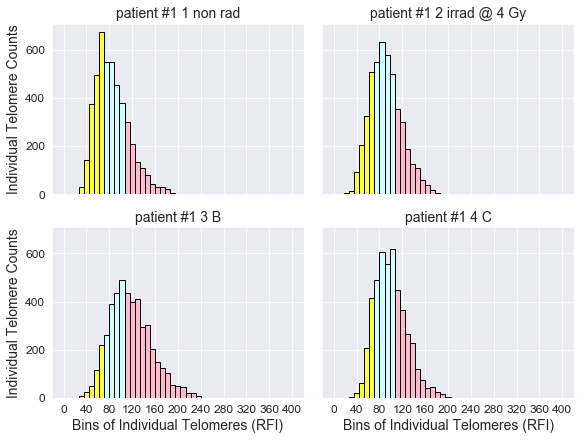

In [13]:
# graphing individual telomeres by individual per timepoint

patient_ids = list(all_patients_df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', data=exploded_telos_all_patients_df, 
                          groupby='patient id', iterable=patient_ids, n_bins=45)

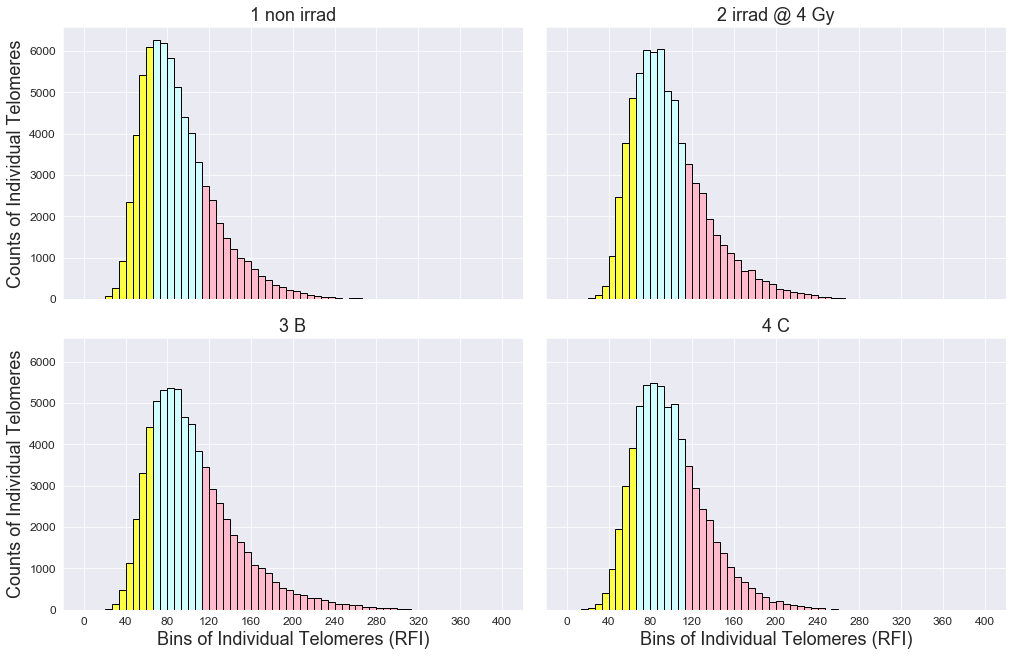

In [81]:
# graphing individual telomeres by timepoint

time_points = list(all_patients_df['timepoint'].unique())
trp.histogram_plot_groups(x='individual telomeres', data=exploded_telos_all_patients_df, 
                               groupby='timepoint', iterable=time_points)

### Feature Engineering Short/Long Individual Telomeres

In [7]:
melted_all_patients_df = pd.melt(
    all_patients_df,
    id_vars = [col for col in all_patients_df.columns if col != 'Q1' and col != 'Q2-3' and col != 'Q4'],
    var_name='relative Q',
    value_name='Q freq counts')

melted_all_patients_df['Q freq counts'] = melted_all_patients_df['Q freq counts'].astype('float64')
melted_all_patients_df.head(4)

,patient id,timepoint,telo data,chr data,status,telo means,relative Q,Q freq counts
0,1,1 non irrad,"[106.6424579997861, 57.016759722657916, 60.184...",chr data,IT WORKS PEGGY <333,84.796738,Q1,1195.0
1,1,2 irrad @ 4 Gy,"[96.0837987918865, 55.960893801867954, 136.206...",chr data,IT WORKS PEGGY <333,90.975987,Q1,724.0
2,1,3 B,"[98.19553063346642, 148.87709483138457, 115.08...",chr data,IT WORKS PEGGY <333,116.780229,Q1,231.0
3,1,4 C,"[59.12849156423784, 98.19553063346642, 116.145...",chr data,IT WORKS PEGGY <333,99.346663,Q1,372.0


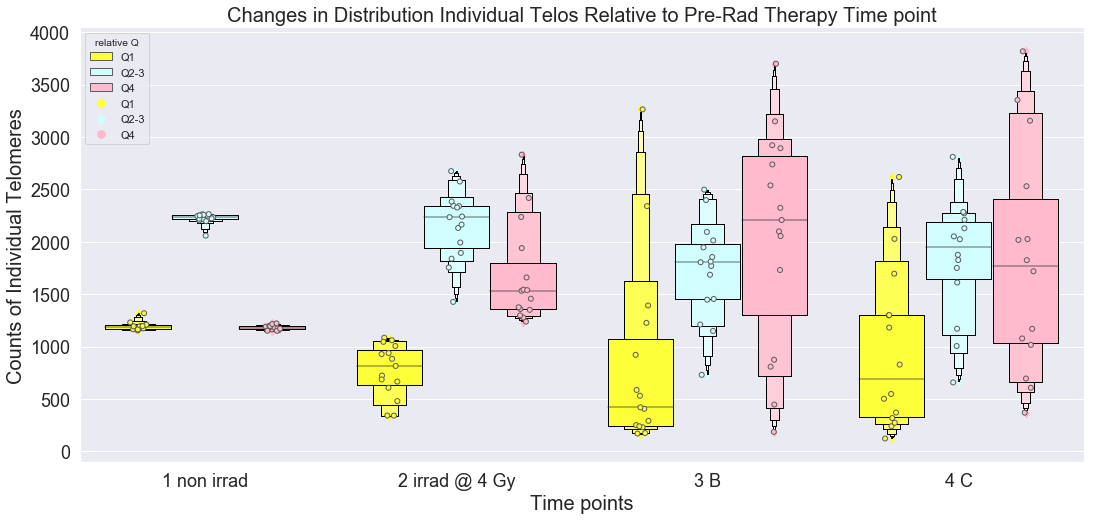

In [16]:
ax = sns.set(font_scale=1)
fig = plt.figure(figsize=(18,8))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}

ax = sns.boxenplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=2, saturation=5, color="black", )
ax = sns.stripplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=1, color="black", dodge=True, )


ax=fig.gca()
ax.set_title('Changes in Distribution Individual Telos Relative to Pre-Rad Therapy Time point', fontsize=20)
ax.set_xlabel('Time points', fontsize=20)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=20)
ax.tick_params(labelsize=18)

plt.savefig('../graphs/telomere length/examining changes in individual telomere lengths per quartile.png', dpi=400)

# Analyzing Telomere Length Data from qPCR (Aidan/Lynn)
---

In [41]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')

In [42]:
all_qPCR_df.head()

,patient id,timepoint,telo means qPCR,SEM
0,1,1 non irrad,2.182028,0.083233
1,1,3 B,1.964348,0.051942
2,1,4 C,1.749799,0.068195
3,2,1 non irrad,1.669445,0.034776
4,2,3 B,1.780092,0.066181


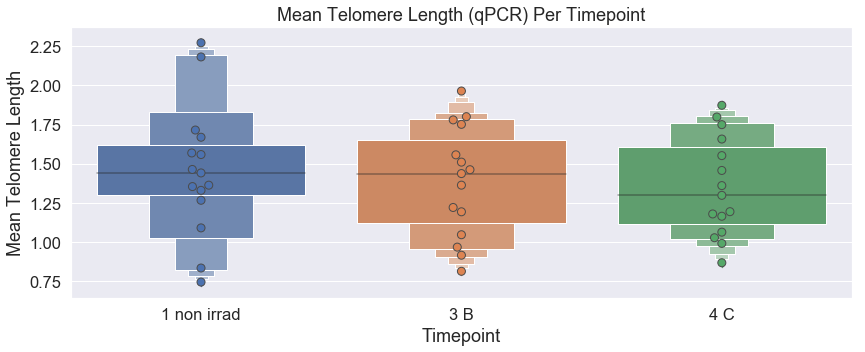

In [43]:
fig = plt.figure(figsize=(14,5))
ax = sns.set(font_scale = 1.5)

ax= sns.boxenplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1)
ax= sns.swarmplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1, size=8)

ax.set_title("Mean Telomere Length (qPCR) Per Timepoint") 
ax.set_ylabel('Mean Telomere Length')
ax.set_xlabel('Timepoint')
plt.savefig('../graphs/telomere length/all patient telomere length means qPCR.png', dpi=400)

## Correlations and Linear Regressions 

In [44]:
pivot_qPCR_df = all_qPCR_df.pivot(index='patient id', columns='timepoint', values='telo means qPCR')
pivot_qPCR_df['constant'] = 1
display(
pivot_qPCR_df.head(4),
pivot_qPCR_df.corr())

timepoint,1 non irrad,3 B,4 C,constant
patient id,,,,
1,2.182028,1.964348,1.749799,1
2,1.669445,1.780092,1.657974,1
3,1.354539,1.557154,1.552189,1
5,1.441672,1.751774,1.798568,1


timepoint,1 non irrad,3 B,4 C,constant
timepoint,,,,
1 non irrad,1.000000,0.765298,0.769699,NaN
3 B,0.765298,1.000000,0.880080,NaN
4 C,0.769699,0.880080,1.000000,NaN
constant,NaN,NaN,NaN,NaN


In [45]:
x_name = '1 non irrad'
y_name = '4 C'

x = pivot_qPCR_df[['1 non irrad']].values.reshape(-1, 1)
y = pivot_qPCR_df['4 C'].values.reshape(-1, 1)

regression = LinearRegression().fit(x, y)
print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for 1 non irrad vs. 4 C:
R2 is 0.5924


In [46]:
x_name = '3 B', '1 non irrad'
y_name = '4 C'

x = pivot_qPCR_df[['3 B', '1 non irrad']].values.reshape(-1, 2)
y = pivot_qPCR_df['4 C'].values.reshape(-1, 1)

regression = LinearRegression().fit(x, y)
print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ('3 B', '1 non irrad') vs. 4 C:
R2 is 0.7969


In [56]:
target = pivot_qPCR_df['4 C']


linear_m = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', 'constant']], missing='drop')
results = linear_m.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    4 C   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     18.90
Date:                Tue, 17 Sep 2019   Prob (F-statistic):           0.000791
Time:                        10:43:42   Log-Likelihood:                 3.1384
No. Observations:                  15   AIC:                            -2.277
Df Residuals:                      13   BIC:                           -0.8606
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
1 non irrad     0.5885      0.135      4.347      

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [57]:
linear_m2 = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', '3 B', 'constant']], missing='drop')
results2 = linear_m2.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                    4 C   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     23.54
Date:                Tue, 17 Sep 2019   Prob (F-statistic):           7.03e-05
Time:                        10:43:42   Log-Likelihood:                 8.3608
No. Observations:                  15   AIC:                            -10.72
Df Residuals:                      12   BIC:                            -8.598
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
1 non irrad     0.1775      0.155      1.148      

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


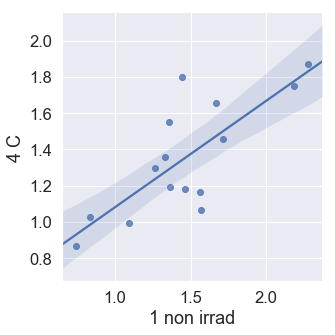

In [58]:
sns.lmplot(x='1 non irrad', y='4 C', data=pivot_qPCR_df, fit_reg=True)

## Statistics 

In [127]:
# conducting one-way repeated measures ANOVA for mean telomere length

df2 = all_qPCR_df

g_1 = df2[df2['timepoint'] == '1 non irrad']['telo means qPCR']
g_3 = df2[df2['timepoint'] == '3 B']['telo means qPCR']
g_4 = df2[df2['timepoint'] == '4 C']['telo means qPCR']

stats.f_oneway(g_1, g_3, g_4)

F_onewayResult(statistic=0.33940643369655527, pvalue=0.714128148014912)

# Analyzing Chromosome Aberration Data from dGH
---

In [7]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')
general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False, adjust_clonality=True))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

In [8]:
melt_aberrations = pd.melt(cleaned_chr_df, id_vars=['patient id', 'timepoint'],
                           var_name='aberration type', value_name='count per cell')

melt_aberrations['count per cell'] = melt_aberrations['count per cell'].astype('int64')
melt_aberrations['aberration type'] = melt_aberrations['aberration type'].astype('str')

## Visualizing Chromosome Rearrangements

In [50]:
# melt_aberrations_chr_only = melt_aberrations[~melt_aberrations['aberration type'].isin(['# sub-telo SCEs', 'tricentrics',
#                                                                                         '# dicentrics', '# translocations',
#                                                                                         '# sat associations', 'cell number'])].copy()

# ax = sns.set(font_scale=2)
# ax = sns.catplot(y='aberration type', x='count per cell', hue='chromosome', 
#                  col='timepoint', col_wrap=2, 
#                  data=melt_aberrations_chr_only, kind='bar', height=7, aspect=1.5, orient="h",)

# ax.set_ylabels('')
# ax.set_xlabels('average count per cell')

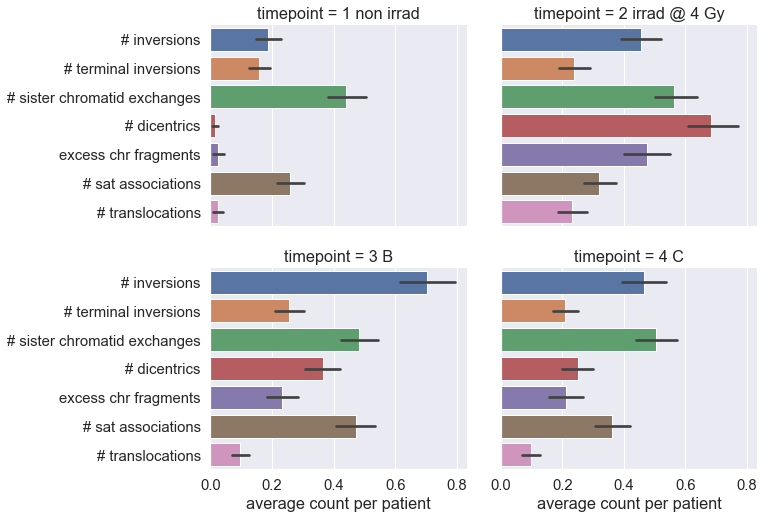

In [51]:
ax = sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
ax = sns.set(font_scale=1.35)
ax = sns.catplot(y='aberration type', x='count per cell',
                 col='timepoint', col_wrap=2,  
                 data=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'], 
                 kind='bar', height=3.75, aspect=1.5, orient="h",)

ax.set_ylabels('')
ax.set_xlabels('average count per patient')

# ax.savefig('../graphs/chromosome aberr/all patients rearrangements.png', dpi=400)

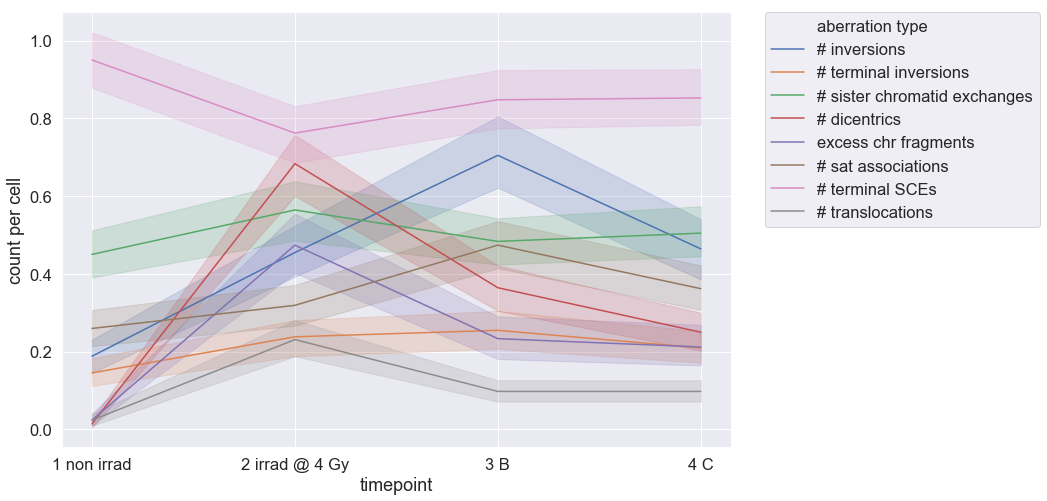

In [42]:
plt.figure(figsize=(12,8))
ax=sns.set(font_scale=1.5)
ax = sns.lineplot(x='timepoint', y='count per cell', data=melt_aberrations,
                  hue='aberration type', 
#                   palette=sns.color_palette("terrain", melt_aberrations['aberration type'].nunique()),
                  )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

In [4]:
rad_type = ['# inversions', '# terminal inversions', '# dicentrics', '# translocations', 'excess chr fragments']
rad_chr = melt_aberrations[melt_aberrations['aberration type'].isin(rad_type)]

# g = sns.set(font_scale=1.25)
g = sns.FacetGrid(melt_aberrations, hue='aberration type', col='patient id', col_wrap=4, 
                  height=5, aspect=1.5, legend_out=True)
g = g.map(sns.lineplot, "timepoint", "count per cell", ci=None).add_legend()

NameError: name 'melt_aberrations' is not defined

## Statistics Chromosome Rearrangements

In [10]:
# conducting one-way ANOVA for chr rearrangements

df = melt_aberrations
aberr_type = list(df['aberration type'].unique())

for aberr in aberr_type:

    g_1 = df[(df['timepoint'] == '1 non irrad') & (df['aberration type'] == aberr)]['count per cell']
    g_2 = df[(df['timepoint'] == '2 irrad @ 4 Gy') & (df['aberration type'] == aberr)]['count per cell']
    g_3 = df[(df['timepoint'] == '3 B') & (df['aberration type'] == aberr)]['count per cell']
    g_4 = df[(df['timepoint'] == '4 C') & (df['aberration type'] == aberr)]['count per cell']
    
    print(aberr, stats.f_oneway(g_1, g_2, g_3, g_4))

# inversions F_onewayResult(statistic=34.771709285988884, pvalue=8.463178205140987e-22)
# terminal inversions F_onewayResult(statistic=4.789038651854537, pvalue=0.0025119885979506588)
# sister chromatid exchanges F_onewayResult(statistic=2.148298985985359, pvalue=0.09228359104764577)
# dicentrics F_onewayResult(statistic=100.69126665815504, pvalue=6.281341006480331e-60)
excess chr fragments F_onewayResult(statistic=43.13490479005828, pvalue=7.540597187851028e-27)
# sat associations F_onewayResult(statistic=10.523970587809067, pvalue=7.394220370605072e-07)
# terminal SCEs F_onewayResult(statistic=4.430979426872743, pvalue=0.004136720193053544)
# translocations F_onewayResult(statistic=28.128194644963745, pvalue=9.597161804580784e-18)


In [54]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

aberr_freq = df

mc = MultiComparison(df[df['aberration type'] == '# inversions']['count per cell'], 
                     df[df['aberration type'] == '# inversions']['timepoint'])
mc_results = mc.tukeyhsd()
print(mc_results)

      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.2667   0.1365  0.3969  True 
 1 non irrad        3 B        0.5167   0.3865  0.6469  True 
 1 non irrad        4 C        0.2762   0.146   0.4064  True 
2 irrad @ 4 Gy      3 B         0.25    0.1198  0.3802  True 
2 irrad @ 4 Gy      4 C        0.0095  -0.1207  0.1397 False 
     3 B            4 C       -0.2405  -0.3707 -0.1103  True 
-------------------------------------------------------------


In [671]:
cleaned_chr_df.head(2)

,patient id,timepoint,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,excess chr fragments,# sat associations,# terminal SCEs,# translocations
0,1,1 non irrad,0,0,1,0,0,0,0,0
1,1,1 non irrad,0,1,2,0,0,1,0,0


In [25]:
# pivoting out inversions for linear regression

group_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()
pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values='# inversions')
pivot_chr.head()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C
patient id,,,,
1,0.066667,0.466667,0.800000,0.300000
2,0.200000,0.600000,0.766667,0.600000
3,0.200000,0.400000,0.900000,0.633333
5,0.200000,0.600000,0.666667,0.533333
6,0.166667,0.200000,0.633333,0.366667


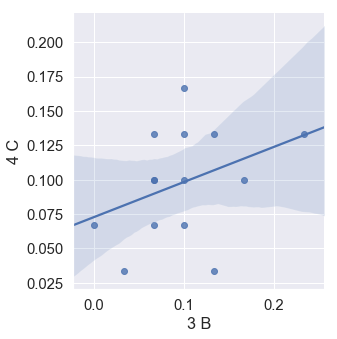

In [24]:
sns.lmplot(x='3 B', y='4 C', data=pivot_chr)

In [11]:
aberr_types = [col for col in group_chr.columns if col != 'patient id' and col != 'timepoint']

for aberr in aberr_types:
    pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values=aberr)
    x_name2 = ['1 non irrad']
    x_name3 = ['2 irrad @ 4 Gy', '1 non irrad']
    y_name = '4 C'

    print(f'ABERRATION TYPE | {aberr}')
    for x_name in [x_name2, x_name3]:
        x = pivot_chr[x_name].values.reshape(-1, len(x_name))
        y = pivot_chr['4 C'].values.reshape(-1, 1)

        regression = LinearRegression().fit(x, y)
        print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
    print('\n')

NameError: name 'group_chr' is not defined

# Merge Telomere Length by TeloFISH & qPCR with Chromosome Aberrations from dGH

In [82]:
group_cleaned_chr_abber_df = group_cleaned_chr_abber_df[group_cleaned_chr_abber_df['timepoint'] != '2 irrad @ 4 Gy']

all_qPCR_chr_aberr = all_qPCR_df.merge(group_cleaned_chr_abber_df, on=['patient id', 'timepoint'])

In [83]:
all_qPCR_chr_aberr

,patient id,timepoint,telo means qPCR,SEM,chromosome,# inversions,# terminal inversions,# sub-telo SCEs,# sister chromatid exchanges,dicentrics,tricentrics,chr fragments,expected chr fragments,excess chr fragments,# sat associations,# terminal SCEs,# translocations
0,1,1 non irrad,2.182028,0.083233,2.0,0.022222,0.055556,0.455556,0.211111,0.000000,0.0,0.000000,0.000000,0.000000,0.044444,0.188889,0.011111
1,1,3 B,1.964348,0.051942,2.0,0.266667,0.155556,0.600000,0.233333,0.122222,0.0,0.266667,0.122222,0.144444,0.255556,0.266667,0.033333
2,1,4 C,1.749799,0.068195,2.0,0.100000,0.088889,0.488889,0.311111,0.022222,0.0,0.111111,0.022222,0.088889,0.122222,0.255556,0.044444
3,2,1 non irrad,1.669445,0.034776,2.0,0.066667,0.033333,0.388889,0.177778,0.000000,0.0,0.011111,0.000000,0.011111,0.111111,0.255556,0.011111
4,2,3 B,1.780092,0.066181,2.0,0.355556,0.100000,0.422222,0.233333,0.100000,0.0,0.155556,0.100000,0.055556,0.155556,0.333333,0.011111
5,2,4 C,1.657974,0.018744,2.0,0.200000,0.088889,0.466667,0.244444,0.155556,0.0,0.255556,0.155556,0.100000,0.122222,0.255556,0.011111
6,3,1 non irrad,1.354539,0.018292,2.0,0.066667,0.055556,0.466667,0.166667,0.011111,0.0,0.011111,0.011111,0.000000,0.122222,0.344444,0.022222
7,3,3 B,1.557154,0.051560,2.0,0.366667,0.033333,0.288889,0.166667,0.144444,0.0,0.233333,0.144444,0.088889,0.255556,0.233333,0.077778
8,3,4 C,1.552189,0.036392,2.0,0.211111,0.011111,0.411111,0.177778,0.100000,0.0,0.222222,0.100000,0.122222,0.166667,0.277778,0.044444
9,5,1 non irrad,1.441672,0.017782,2.0,0.066667,0.100000,0.533333,0.144444,0.022222,0.0,0.022222,0.022222,0.000000,0.100000,0.388889,0.000000
